In [ ]:
!pip install keras-ocr
!pip install keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 998.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.2 MB/s eta 0:00:00


In [ ]:
!pip show pandas

Name: pandas
Version: 1.5.3
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: The Pandas Development Team
Author-email: pandas-dev@python.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, python-dateutil, pytz
Required-by: altair, arviz, bigframes, bokeh, bqplot, cmdstanpy, cufflinks, datascience, db-dtypes, dopamine-rl, fastai, geemap, geopandas, google-colab, gspread-dataframe, holoviews, ibis-framework, lida, mizani, mlxtend, pandas-datareader, pandas-gbq, panel, plotnine, prophet, pymc, seaborn, sklearn-pandas, statsmodels, vega-datasets, xarray, yfinance


In [ ]:
import numpy as np
import pandas as pd
import cv2
from glob import glob
import spacy
import re
import string
import tensorflow as tf
import keras_ocr
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
def cleanText(txt):
  whitespace = string.whitespace
  punctuation = "!#$%&\'()*+:;<=>?[\\]^`{|}~"
  tableWhitespace = str.maketrans('','',whitespace)
  tablePunctuation = str.maketrans('','',punctuation)
  text = str(txt)
  text = text.lower()
  removewhitespace = text.translate(tableWhitespace)
  removepunctuation = removewhitespace.translate(tablePunctuation)

  return str(removepunctuation)

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_ner = spacy.load('/content/drive/MyDrive/MedEase/Models/NER/spaCy')

In [ ]:
def perform_ocr(input_image):
  pipeline = keras_ocr.pipeline.Pipeline()
  images = [input_image]
  predictions = pipeline.recognize(images)
  return predictions[0]

In [ ]:
def preprocess_image(image_path):
  resize = resize_images(image_path)  # 1920 x 1080
  saturation = adjust_saturation(resize)  # 2
  contrast = adjust_contrast(saturation)  # 2
  return contrast

In [ ]:
def resize_images(input_image, target_size=(1920, 1080)):
  resized_image = tf.image.resize_with_pad(input_image, target_size[0], target_size[1])
  resized_image = tf.cast(resized_image, tf.uint8)
  return resized_image

def adjust_saturation(input_image):
  saturated_image = tf.image.adjust_saturation(input_image, saturation_factor=2)
  saturated_image = tf.cast(saturated_image, tf.uint8)
  return saturated_image

def adjust_contrast(input_image):
  contrast_image = tf.image.adjust_contrast(input_image, contrast_factor=2)
  contrast_image = tf.cast(contrast_image, tf.uint8)
  return contrast_image

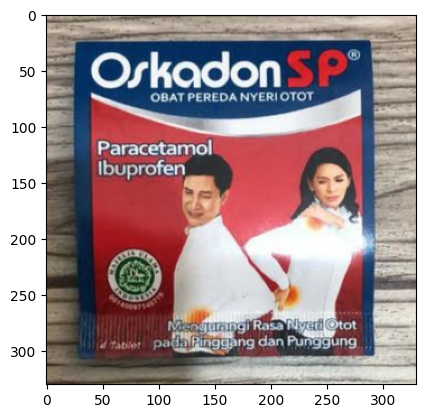

In [ ]:
image_path = '/content/drive/MyDrive/MedEase/Dataset/Dataset_Clean/Oskadon-SP/IMG_20231122_161711.jpg'
image = keras_ocr.tools.read(image_path)

plt.imshow(image)
plt.show()

In [ ]:
ocrData = perform_ocr(image)
text_from_ocr = " ".join([text_result[0] for text_result in ocrData])
print(text_from_ocr)

Looking for /root/.keras-ocr/craft_mlt_25k.h5


Instructions for updating:
Use `tf.image.resize(...method=ResizeMethod.BILINEAR...)` instead.


Looking for /root/.keras-ocr/crnn_kurapan.h5
1/1 [==============================] - 4s 4s/step
sp oskadon nyeri otot obat pereda paracetamol ibuprofen nyetiotot rasa menguiing padalinggang punggung dan


In [ ]:
columns = ['image_path', 'text', 'boxes']
df = pd.DataFrame(columns=columns)

for text_result in ocrData:
  text = text_result[0]
  boxes = text_result[1]
  # Append the information to the DataFrame
  df = df.append({'image_path': image_path, 'text': text, 'boxes': boxes}, ignore_index=True)

df.dropna(inplace=True)
df['text'] = df['text'].apply(cleanText)
df_clean = df[df['text'] != ""]
df_clean

,image_path,text,boxes
0,/content/drive/MyDrive/MedEase/Dataset/Dataset...,sp,"[[213.31009, 31.233027], [271.65045, 29.465136..."
1,/content/drive/MyDrive/MedEase/Dataset/Dataset...,oskadon,"[[40.0, 32.0], [212.99997, 32.0], [212.99997, ..."
2,/content/drive/MyDrive/MedEase/Dataset/Dataset...,nyeri,"[[172.0, 68.0], [208.0, 68.0], [208.0, 79.0], ..."
3,/content/drive/MyDrive/MedEase/Dataset/Dataset...,otot,"[[208.0, 68.0], [240.0, 68.0], [240.0, 79.0], ..."
4,/content/drive/MyDrive/MedEase/Dataset/Dataset...,obat,"[[92.0, 69.0], [124.0, 69.0], [124.0, 80.0], [..."
5,/content/drive/MyDrive/MedEase/Dataset/Dataset...,pereda,"[[125.0, 69.0], [171.0, 69.0], [171.0, 79.0], ..."
6,/content/drive/MyDrive/MedEase/Dataset/Dataset...,paracetamol,"[[45.0, 112.0], [151.0, 112.0], [151.0, 129.0]..."
7,/content/drive/MyDrive/MedEase/Dataset/Dataset...,ibuprofen,"[[44.0, 129.0], [126.0, 129.0], [126.0, 150.0]..."
8,/content/drive/MyDrive/MedEase/Dataset/Dataset...,nyetiotot,"[[212.6329, 272.0877], [279.76303, 269.60138],..."
9,/content/drive/MyDrive/MedEase/Dataset/Dataset...,rasa,"[[184.0, 272.0], [213.0, 272.0], [213.0, 284.0..."


In [ ]:
doc = model_ner(text_from_ocr)
for ent in doc.ents:
    print(f"Entity: {ent.text}, Label: {ent.label_}")

Entity: sp, Label: I-NAME
Entity: oskadon, Label: B-NAME
Entity: nyeri, Label: I-DES
Entity: otot, Label: I-DES
Entity: obat, Label: B-DES
Entity: pereda, Label: I-DES
Entity: paracetamol, Label: B-ING
Entity: ibuprofen, Label: B-ING
Entity: nyetiotot, Label: I-DES
Entity: rasa, Label: I-DES
Entity: padalinggang, Label: B-DES
Entity: punggung, Label: I-DES
Entity: dan, Label: I-DES


In [ ]:
from spacy import displacy
displacy.render(doc,style='ent')

'<div class="entities" style="line-height: 2.5; direction: ltr">\n<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    sp\n    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">I-NAME</span>\n</mark>\n \n<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    oskadon\n    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">B-NAME</span>\n</mark>\n \n<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    nyeri\n    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">I-DES</span>\n</mark>\n \n<mark class="entity" 

<div class="entities" style="line-height: 2.5; direction: ltr">
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    sp
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">I-NAME</span>
</mark>

<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    oskadon
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">B-NAME</span>
</mark>

<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    nyeri
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">I-DES</span>
</mark>

<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    otot
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">I-DES</span>
</mark>

<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    obat
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">B-DES</span>
</mark>

<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    pereda
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">I-DES</span>
</mark>

<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    paracetamol
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">B-ING</span>
</mark>

<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    ibuprofen
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">B-ING</span>
</mark>

<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    nyetiotot
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">I-DES</span>
</mark>

<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    rasa
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">I-DES</span>
</mark>
 menguiing
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    padalinggang
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">B-DES</span>
</mark>

<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    punggung
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">I-DES</span>
</mark>

<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    dan
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">I-DES</span>
</mark>
</div>

Tagging

In [ ]:
docjson = doc.to_json()
docjson.keys()

doc_text = docjson['text']

In [ ]:
dataframe_tokens = pd.DataFrame(docjson['tokens'])
dataframe_tokens['token'] = dataframe_tokens[['start', 'end']].apply(lambda x:doc_text[x[0]:x[1]], axis=1)
dataframe_tokens.head(10)

,id,start,end,tag,pos,morph,lemma,dep,head,token
0,0,0,2,UH,INTJ,,sp,intj,10,sp
1,1,3,10,NNP,PROPN,Number=Sing,oskadon,compound,2,oskadon
2,2,11,16,NNP,PROPN,Number=Sing,nyeri,compound,9,nyeri
3,3,17,21,NNP,PROPN,Number=Sing,otot,advmod,5,otot
4,4,22,26,NNP,PROPN,Number=Sing,obat,compound,5,obat
5,5,27,33,NNP,PROPN,Number=Sing,pereda,compound,6,pereda
6,6,34,45,NNP,PROPN,Number=Sing,paracetamol,compound,9,paracetamol
7,7,46,55,NNP,PROPN,Number=Sing,ibuprofen,compound,9,ibuprofen
8,8,56,65,NNP,PROPN,Number=Sing,nyetiotot,compound,9,nyetiotot
9,9,66,70,NN,NOUN,Number=Sing,rasa,pobj,0,rasa


In [ ]:
right_table = pd.DataFrame(docjson['ents'])[['start', 'label']]
dataframe_tokens = pd.merge(dataframe_tokens, right_table, how='left', on='start')

In [ ]:
dataframe_tokens.fillna('O',inplace=True)
dataframe_tokens.head(10)

,id,start,end,tag,pos,morph,lemma,dep,head,token,label
0,0,0,2,UH,INTJ,,sp,intj,10,sp,I-NAME
1,1,3,10,NNP,PROPN,Number=Sing,oskadon,compound,2,oskadon,B-NAME
2,2,11,16,NNP,PROPN,Number=Sing,nyeri,compound,9,nyeri,I-DES
3,3,17,21,NNP,PROPN,Number=Sing,otot,advmod,5,otot,I-DES
4,4,22,26,NNP,PROPN,Number=Sing,obat,compound,5,obat,B-DES
5,5,27,33,NNP,PROPN,Number=Sing,pereda,compound,6,pereda,I-DES
6,6,34,45,NNP,PROPN,Number=Sing,paracetamol,compound,9,paracetamol,B-ING
7,7,46,55,NNP,PROPN,Number=Sing,ibuprofen,compound,9,ibuprofen,B-ING
8,8,56,65,NNP,PROPN,Number=Sing,nyetiotot,compound,9,nyetiotot,I-DES
9,9,66,70,NN,NOUN,Number=Sing,rasa,pobj,0,rasa,I-DES


In [ ]:
df_clean['end'] = df_clean['text'].apply(lambda x: len(x) + 1).cumsum() - 1
df_clean['start'] = df_clean[['text', 'end']].apply(lambda x: x[1] - len(x[0]), axis=1)

In [ ]:
dataframe_info = pd.merge(df_clean, dataframe_tokens[['start', 'token', 'label']], how='inner', on='start')

In [ ]:
dataframe_info.tail(10)

,image_path,text,boxes,end,start,token,label
4,/content/drive/MyDrive/MedEase/Dataset/Dataset...,obat,"[[92.0, 69.0], [124.0, 69.0], [124.0, 80.0], [...",26,22,obat,B-DES
5,/content/drive/MyDrive/MedEase/Dataset/Dataset...,pereda,"[[125.0, 69.0], [171.0, 69.0], [171.0, 79.0], ...",33,27,pereda,I-DES
6,/content/drive/MyDrive/MedEase/Dataset/Dataset...,paracetamol,"[[45.0, 112.0], [151.0, 112.0], [151.0, 129.0]...",45,34,paracetamol,B-ING
7,/content/drive/MyDrive/MedEase/Dataset/Dataset...,ibuprofen,"[[44.0, 129.0], [126.0, 129.0], [126.0, 150.0]...",55,46,ibuprofen,B-ING
8,/content/drive/MyDrive/MedEase/Dataset/Dataset...,nyetiotot,"[[212.6329, 272.0877], [279.76303, 269.60138],...",65,56,nyetiotot,I-DES
9,/content/drive/MyDrive/MedEase/Dataset/Dataset...,rasa,"[[184.0, 272.0], [213.0, 272.0], [213.0, 284.0...",70,66,rasa,I-DES
10,/content/drive/MyDrive/MedEase/Dataset/Dataset...,menguiing,"[[109.051254, 273.8235], [183.11263, 275.018],...",80,71,menguiing,O
11,/content/drive/MyDrive/MedEase/Dataset/Dataset...,padalinggang,"[[94.0, 286.0], [188.0, 286.0], [188.0, 302.0]...",93,81,padalinggang,B-DES
12,/content/drive/MyDrive/MedEase/Dataset/Dataset...,punggung,"[[214.05862, 285.8344], [279.24, 287.0415], [2...",102,94,punggung,I-DES
13,/content/drive/MyDrive/MedEase/Dataset/Dataset...,dan,"[[188.0, 287.0], [213.0, 287.0], [213.0, 298.0...",106,103,dan,I-DES


Bounding Box

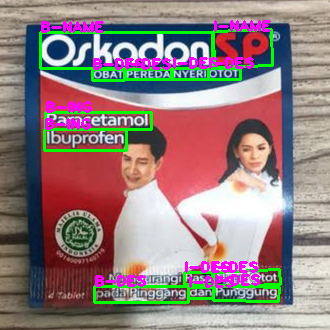

In [ ]:
from google.colab.patches import cv2_imshow

img_bb1 = image.copy()
bb_df = dataframe_info.query("label != 'O' ")

for boxes, label in bb_df[['boxes', 'label']].values:
    # boxes = eval(boxes)

    boxes = [(int(x), int(y)) for x, y in boxes]
    cv2.polylines(img_bb1, [np.array(boxes)], isClosed=True, color=(0, 255, 0), thickness=2)

    x, y = boxes[0]
    cv2.putText(img_bb1, str(label), (x, y), cv2.FONT_HERSHEY_PLAIN, 1, (255, 0, 255), 2)

img_bb1 = cv2.cvtColor(img_bb1, cv2.COLOR_BGR2RGB)
# img_bb1 = cv2.resize(img_bb1, (720, 1280))
cv2_imshow(img_bb1)

In [ ]:
bb_df

,image_path,text,boxes,end,start,token,label
0,/content/drive/MyDrive/MedEase/Dataset/Dataset...,sp,"[[213.31009, 31.233027], [271.65045, 29.465136...",2,0,sp,I-NAME
1,/content/drive/MyDrive/MedEase/Dataset/Dataset...,oskadon,"[[40.0, 32.0], [212.99997, 32.0], [212.99997, ...",10,3,oskadon,B-NAME
2,/content/drive/MyDrive/MedEase/Dataset/Dataset...,nyeri,"[[172.0, 68.0], [208.0, 68.0], [208.0, 79.0], ...",16,11,nyeri,I-DES
3,/content/drive/MyDrive/MedEase/Dataset/Dataset...,otot,"[[208.0, 68.0], [240.0, 68.0], [240.0, 79.0], ...",21,17,otot,I-DES
4,/content/drive/MyDrive/MedEase/Dataset/Dataset...,obat,"[[92.0, 69.0], [124.0, 69.0], [124.0, 80.0], [...",26,22,obat,B-DES
5,/content/drive/MyDrive/MedEase/Dataset/Dataset...,pereda,"[[125.0, 69.0], [171.0, 69.0], [171.0, 79.0], ...",33,27,pereda,I-DES
6,/content/drive/MyDrive/MedEase/Dataset/Dataset...,paracetamol,"[[45.0, 112.0], [151.0, 112.0], [151.0, 129.0]...",45,34,paracetamol,B-ING
7,/content/drive/MyDrive/MedEase/Dataset/Dataset...,ibuprofen,"[[44.0, 129.0], [126.0, 129.0], [126.0, 150.0]...",55,46,ibuprofen,B-ING
8,/content/drive/MyDrive/MedEase/Dataset/Dataset...,nyetiotot,"[[212.6329, 272.0877], [279.76303, 269.60138],...",65,56,nyetiotot,I-DES
9,/content/drive/MyDrive/MedEase/Dataset/Dataset...,rasa,"[[184.0, 272.0], [213.0, 272.0], [213.0, 284.0...",70,66,rasa,I-DES


In [ ]:
def custom_sort(row):
  label = row['label']
  start = row['start']
  if label.startswith('B-NAME'):
    return (0, start, label)
  elif label.startswith('I-NAME'):
    return (1, start, label)
  else:
    return (2, start, label)

In [ ]:
bb_df['sorting_key'] = bb_df.apply(custom_sort, axis=1)
df_sorted = bb_df.sort_values(by='sorting_key').drop('sorting_key', axis=1).reset_index(drop=True)
df_sorted

,image_path,text,boxes,end,start,token,label
0,/content/drive/MyDrive/MedEase/Dataset/Dataset...,oskadon,"[[40.0, 32.0], [212.99997, 32.0], [212.99997, ...",10,3,oskadon,B-NAME
1,/content/drive/MyDrive/MedEase/Dataset/Dataset...,sp,"[[213.31009, 31.233027], [271.65045, 29.465136...",2,0,sp,I-NAME
2,/content/drive/MyDrive/MedEase/Dataset/Dataset...,nyeri,"[[172.0, 68.0], [208.0, 68.0], [208.0, 79.0], ...",16,11,nyeri,I-DES
3,/content/drive/MyDrive/MedEase/Dataset/Dataset...,otot,"[[208.0, 68.0], [240.0, 68.0], [240.0, 79.0], ...",21,17,otot,I-DES
4,/content/drive/MyDrive/MedEase/Dataset/Dataset...,obat,"[[92.0, 69.0], [124.0, 69.0], [124.0, 80.0], [...",26,22,obat,B-DES
5,/content/drive/MyDrive/MedEase/Dataset/Dataset...,pereda,"[[125.0, 69.0], [171.0, 69.0], [171.0, 79.0], ...",33,27,pereda,I-DES
6,/content/drive/MyDrive/MedEase/Dataset/Dataset...,paracetamol,"[[45.0, 112.0], [151.0, 112.0], [151.0, 129.0]...",45,34,paracetamol,B-ING
7,/content/drive/MyDrive/MedEase/Dataset/Dataset...,ibuprofen,"[[44.0, 129.0], [126.0, 129.0], [126.0, 150.0]...",55,46,ibuprofen,B-ING
8,/content/drive/MyDrive/MedEase/Dataset/Dataset...,nyetiotot,"[[212.6329, 272.0877], [279.76303, 269.60138],...",65,56,nyetiotot,I-DES
9,/content/drive/MyDrive/MedEase/Dataset/Dataset...,rasa,"[[184.0, 272.0], [213.0, 272.0], [213.0, 284.0...",70,66,rasa,I-DES


In [ ]:
df_sorted['label'] = df_sorted['label'].apply(lambda x: x[2:])
df_sorted.head()

,image_path,text,boxes,end,start,token,label
0,/content/drive/MyDrive/MedEase/Dataset/Dataset...,oskadon,"[[40.0, 32.0], [212.99997, 32.0], [212.99997, ...",10,3,oskadon,NAME
1,/content/drive/MyDrive/MedEase/Dataset/Dataset...,sp,"[[213.31009, 31.233027], [271.65045, 29.465136...",2,0,sp,NAME
2,/content/drive/MyDrive/MedEase/Dataset/Dataset...,nyeri,"[[172.0, 68.0], [208.0, 68.0], [208.0, 79.0], ...",16,11,nyeri,DES
3,/content/drive/MyDrive/MedEase/Dataset/Dataset...,otot,"[[208.0, 68.0], [240.0, 68.0], [240.0, 79.0], ...",21,17,otot,DES
4,/content/drive/MyDrive/MedEase/Dataset/Dataset...,obat,"[[92.0, 69.0], [124.0, 69.0], [124.0, 80.0], [...",26,22,obat,DES


In [ ]:
# group the label
class groupgen():
  def __init__(self):
    self.id = 0
    self.text = ''

  def getgroup(self, text):
    if self.text == text:
      return self.id
    else:
      self.id += 1
      self.text = text
      return self.id

grp_gen = groupgen()

In [ ]:
df_sorted['group'] = df_sorted['label'].apply(grp_gen.getgroup)

In [ ]:
df_sorted[['left', 'top', 'right', 'bottom']] = pd.DataFrame(df_sorted['boxes'].apply(
    lambda boxes: (int(boxes[0][0]), int(boxes[0][1]), int(boxes[2][0]), int(boxes[2][1]))
).tolist(), index=df_sorted.index)
df_sorted

,image_path,text,boxes,end,start,token,label,group,left,top,right,bottom
0,/content/drive/MyDrive/MedEase/Dataset/Dataset...,oskadon,"[[40.0, 32.0], [212.99997, 32.0], [212.99997, ...",10,3,oskadon,NAME,1,40,32,212,68
1,/content/drive/MyDrive/MedEase/Dataset/Dataset...,sp,"[[213.31009, 31.233027], [271.65045, 29.465136...",2,0,sp,NAME,1,213,31,272,65
2,/content/drive/MyDrive/MedEase/Dataset/Dataset...,nyeri,"[[172.0, 68.0], [208.0, 68.0], [208.0, 79.0], ...",16,11,nyeri,DES,2,172,68,208,79
3,/content/drive/MyDrive/MedEase/Dataset/Dataset...,otot,"[[208.0, 68.0], [240.0, 68.0], [240.0, 79.0], ...",21,17,otot,DES,2,208,68,240,79
4,/content/drive/MyDrive/MedEase/Dataset/Dataset...,obat,"[[92.0, 69.0], [124.0, 69.0], [124.0, 80.0], [...",26,22,obat,DES,2,92,69,124,80
5,/content/drive/MyDrive/MedEase/Dataset/Dataset...,pereda,"[[125.0, 69.0], [171.0, 69.0], [171.0, 79.0], ...",33,27,pereda,DES,2,125,69,171,79
6,/content/drive/MyDrive/MedEase/Dataset/Dataset...,paracetamol,"[[45.0, 112.0], [151.0, 112.0], [151.0, 129.0]...",45,34,paracetamol,ING,3,45,112,151,129
7,/content/drive/MyDrive/MedEase/Dataset/Dataset...,ibuprofen,"[[44.0, 129.0], [126.0, 129.0], [126.0, 150.0]...",55,46,ibuprofen,ING,3,44,129,126,150
8,/content/drive/MyDrive/MedEase/Dataset/Dataset...,nyetiotot,"[[212.6329, 272.0877], [279.76303, 269.60138],...",65,56,nyetiotot,DES,4,212,272,280,284
9,/content/drive/MyDrive/MedEase/Dataset/Dataset...,rasa,"[[184.0, 272.0], [213.0, 272.0], [213.0, 284.0...",70,66,rasa,DES,4,184,272,213,284


In [ ]:
col_group = ['left', 'top', 'right', 'bottom', 'label', 'token', 'group']
group_tag_img = df_sorted[col_group].groupby(by='group')

In [ ]:
img_tagging = group_tag_img.agg({
    'left':min,
    'right':max,
    'top':min,
    'bottom':max,
    'label':lambda x: ', '.join(np.unique(x)),
    'token':lambda x: " ".join(x)
})

In [ ]:
img_tagging

,left,right,top,bottom,label,token
group,,,,,,
1,40,272,31,68,NAME,oskadon sp
2,92,240,68,80,DES,nyeri otot obat pereda
3,44,151,112,150,ING,paracetamol ibuprofen
4,94,280,272,302,DES,nyetiotot rasa padalinggang punggung dan


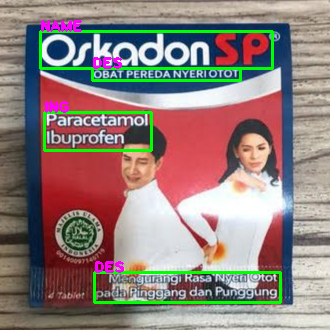

In [ ]:
from google.colab.patches import cv2_imshow

img_bb2 = image.copy()
for l, r, t, b, label, token in img_tagging.values:
    cv2.rectangle(img_bb2, (l, t), (r, b), (0, 255, 0), 2)
    cv2.putText(img_bb2, str(label), (l, t), cv2.FONT_HERSHEY_PLAIN, 1, (255 ,0 ,255), 2)

img_bb2 = cv2.cvtColor(img_bb2, cv2.COLOR_BGR2RGB)
# img_bb2 = cv2.resize(img_bb2, (720, 1280))
cv2_imshow(img_bb2)

In [ ]:
info_array = img_tagging[['token', 'label']].values
entities = dict(NAME=[], ING=[], TYPE=[], DES=[], ORG=[])

for token, label in info_array:
  label_tag = label
  entities[label_tag].append(token)
entities

{'NAME': ['oskadon sp'],
 'ING': ['paracetamol ibuprofen'],
 'TYPE': [],
 'DES': ['nyeri otot obat pereda', 'nyetiotot rasa padalinggang punggung dan'],
 'ORG': []}